<a href="https://colab.research.google.com/github/kzhangaz/GaussianRegression/blob/main/MultitaskGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Install Packages
# %%capture
# !pip install --upgrade gpytorch
#!pip install pykeops[full] > install.log

In [4]:
import math
import torch
import gpytorch
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# fix seeds
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(0)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load data 
## split into targets and features

In [5]:
# load data
data = pd.read_csv("../../GP_task/ke_data.csv",sep=';',index_col=0,decimal=",")
train_x = data.iloc[0,:].astype(np.float32)
train_y = data.iloc[1:,:].astype(np.float32)

# change the format from dataframe to tensor
train_x = torch.tensor(np.array(train_x))
train_y = torch.tensor(np.array(train_y))
# train_y = torch.reshape(train_y, (-1,))
N = train_x.size(dim=0)
m = len(data)-1

## Check if the data are loaded correctly

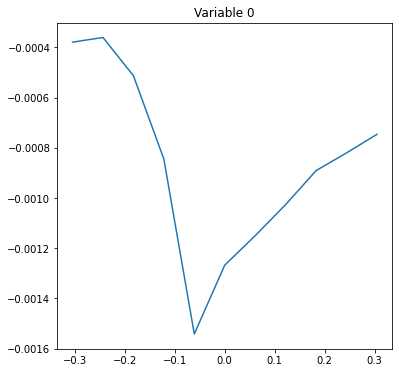

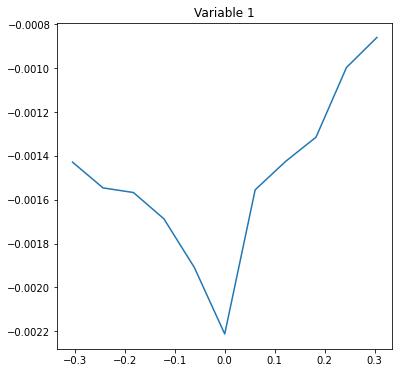

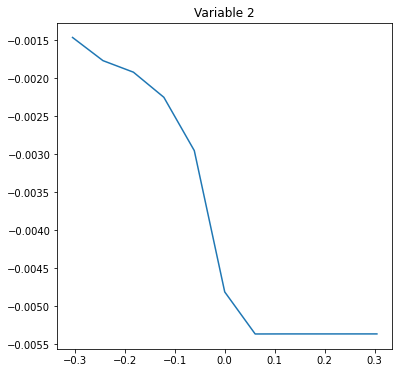

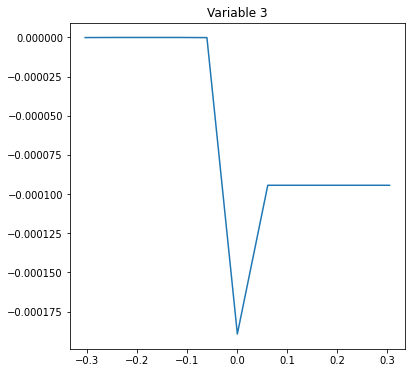

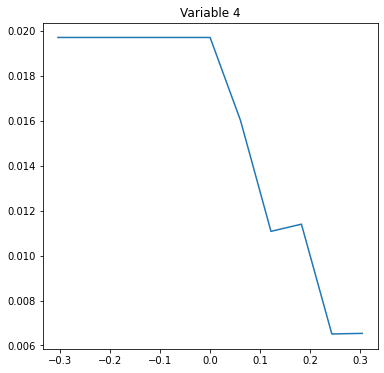

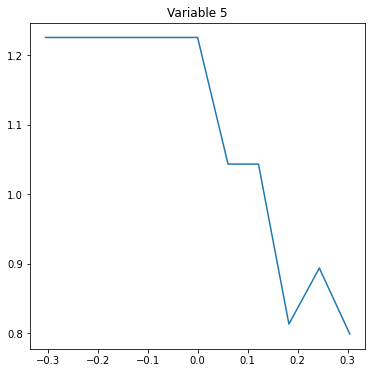

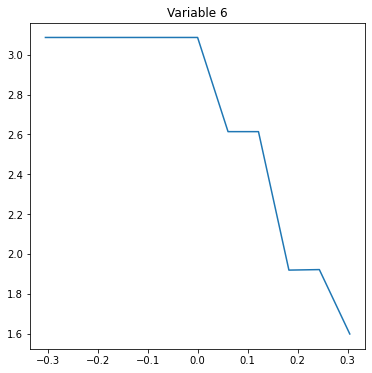

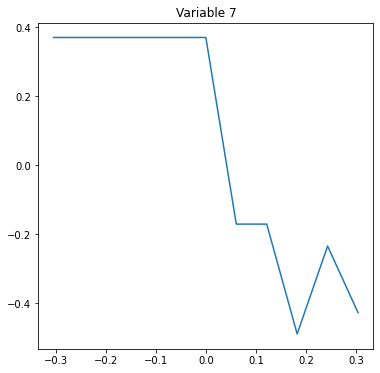

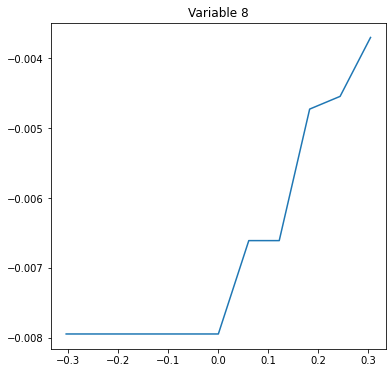

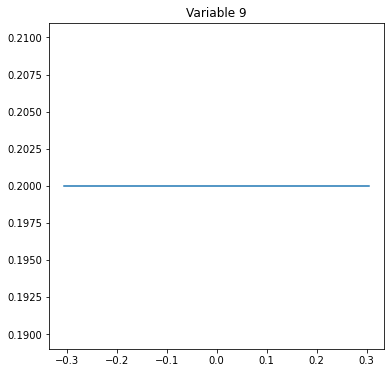

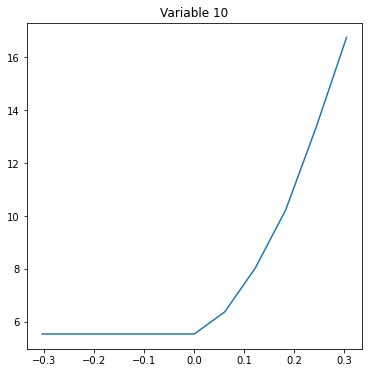

In [6]:
# vars = train_y.shape[0]
for i,var in enumerate(train_y):
    fig  = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.plot(train_x,var)

    ax.set_title(f"Variable {i}")



# Define models

## Multitask
### Assume that all outputs are connected

In [7]:
# define multitask GP model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=m
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=m, rank=1
        )
    # rank???
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


multitask_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=m)
multitask_model = MultitaskGPModel(train_x, train_y, multitask_likelihood)


## Indipendent models
### Assume all outputs are independent

In [8]:
# define indipendent GP model
class independentGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(independentGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# create a model for every output
all_independent_models = []
all_independent_likelihoods = []
for var in train_y:
    
    current_model = independentGP(train_x,var,gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6)))
    
    mean_var = torch.abs(torch.mean(var))
    if mean_var<1e-4:
        mean_var = torch.tensor(1e-4)
    hypers = {
    'likelihood.noise_covar.noise': 0.01 * mean_var.clone().detach().requires_grad_(True),
    'covar_module.outputscale': 0.5*mean_var.clone().detach().requires_grad_(True),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.05).clone().detach().requires_grad_(True),
    }
    current_model.initialize(**hypers)

    all_independent_models.append(current_model)
    all_independent_likelihoods.append(current_model.likelihood)

# define model lists
indipendent_likelihoods = gpytorch.likelihoods.LikelihoodList(*all_independent_likelihoods)
indipendent_models =  gpytorch.models.IndependentModelList(*all_independent_models)

# check this tutorial:
# https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/ModelList_GP_Regression.html

In [9]:
current_model.covar_module.base_kernel.lengthscale

tensor([[0.0500]], grad_fn=<SoftplusBackward>)

## Train

## Multitask

In [10]:
# train multitask_model hyperparameters
training_iter = 400

multitask_model.train()
multitask_likelihood.train()

optimizer = torch.optim.Adam(multitask_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(multitask_likelihood, multitask_model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = multitask_model(train_x)
    # Calc loss and backprop gradients
    # loss = -mll(output, train_y)
    loss = -mll(output, torch.reshape(train_y, (-1,)))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()


Iter 1/400 - Loss: 3.438
Iter 2/400 - Loss: 3.272
Iter 3/400 - Loss: 3.124
Iter 4/400 - Loss: 2.994
Iter 5/400 - Loss: 2.879
Iter 6/400 - Loss: 2.779
Iter 7/400 - Loss: 2.692
Iter 8/400 - Loss: 2.617
Iter 9/400 - Loss: 2.551
Iter 10/400 - Loss: 2.493
Iter 11/400 - Loss: 2.442
Iter 12/400 - Loss: 2.395
Iter 13/400 - Loss: 2.352
Iter 14/400 - Loss: 2.310
Iter 15/400 - Loss: 2.268
Iter 16/400 - Loss: 2.224
Iter 17/400 - Loss: 2.178
Iter 18/400 - Loss: 2.129
Iter 19/400 - Loss: 2.079
Iter 20/400 - Loss: 2.029
Iter 21/400 - Loss: 1.982
Iter 22/400 - Loss: 1.941
Iter 23/400 - Loss: 1.909
Iter 24/400 - Loss: 1.884
Iter 25/400 - Loss: 1.862
Iter 26/400 - Loss: 1.842
Iter 27/400 - Loss: 1.822
Iter 28/400 - Loss: 1.803
Iter 29/400 - Loss: 1.786
Iter 30/400 - Loss: 1.772
Iter 31/400 - Loss: 1.759
Iter 32/400 - Loss: 1.747
Iter 33/400 - Loss: 1.736
Iter 34/400 - Loss: 1.725
Iter 35/400 - Loss: 1.714
Iter 36/400 - Loss: 1.702
Iter 37/400 - Loss: 1.690
Iter 38/400 - Loss: 1.677
Iter 39/400 - Loss: 1

## Indipendent

In [11]:
# train indipendent_model hyperparameters
indipendent_models.train()
indipendent_likelihoods.train()

optimizer = torch.optim.Adam(indipendent_models.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.SumMarginalLogLikelihood(indipendent_likelihoods, indipendent_models)

for i in range(training_iter):
    optimizer.zero_grad()
    output = indipendent_models(*indipendent_models.train_inputs)
    # Calc loss and backprop gradients
    # loss = -mll(output, train_y)
    loss = -mll(output, indipendent_models.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()


Iter 1/400 - Loss: -0.473
Iter 2/400 - Loss: 5.207
Iter 3/400 - Loss: -0.457
Iter 4/400 - Loss: 0.003
Iter 5/400 - Loss: 1.645
Iter 6/400 - Loss: 1.281
Iter 7/400 - Loss: -0.043
Iter 8/400 - Loss: -1.086
Iter 9/400 - Loss: -1.467
Iter 10/400 - Loss: -1.369
Iter 11/400 - Loss: -1.132
Iter 12/400 - Loss: -1.000
Iter 13/400 - Loss: -1.057
Iter 14/400 - Loss: -1.262
Iter 15/400 - Loss: -1.532
Iter 16/400 - Loss: -1.791
Iter 17/400 - Loss: -1.988
Iter 18/400 - Loss: -2.107
Iter 19/400 - Loss: -2.161
Iter 20/400 - Loss: -2.172
Iter 21/400 - Loss: -2.168
Iter 22/400 - Loss: -2.168
Iter 23/400 - Loss: -2.184
Iter 24/400 - Loss: -2.218
Iter 25/400 - Loss: -2.270
Iter 26/400 - Loss: -2.338
Iter 27/400 - Loss: -2.417
Iter 28/400 - Loss: -2.492
Iter 29/400 - Loss: -2.549
Iter 30/400 - Loss: -2.593
Iter 31/400 - Loss: -2.632
Iter 32/400 - Loss: -2.659
Iter 33/400 - Loss: -2.677
Iter 34/400 - Loss: -2.695
Iter 35/400 - Loss: -2.710
Iter 36/400 - Loss: -2.723
Iter 37/400 - Loss: -2.744
Iter 38/400 - 

## Evaluate models

## Multitask
The model learns the same responce for all outputs


In [12]:
# make predictions

# Set into eval mode
multitask_model.eval()
multitask_likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-0.35, 0.35, 101)
    predictions = multitask_likelihood(multitask_model(test_x))
    multitask_mean = predictions.mean
    multitask_lower, multitask_upper = predictions.confidence_region()


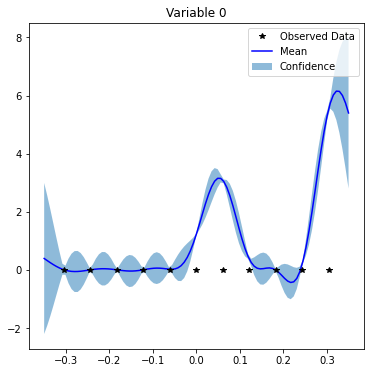

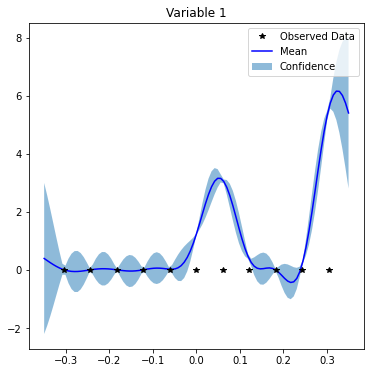

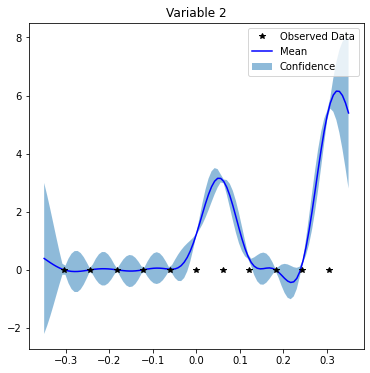

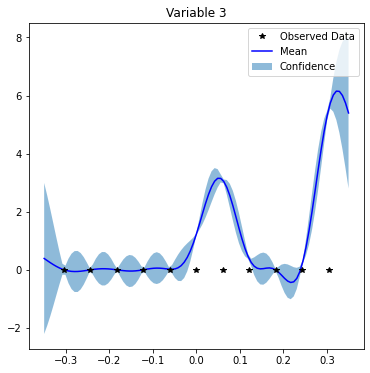

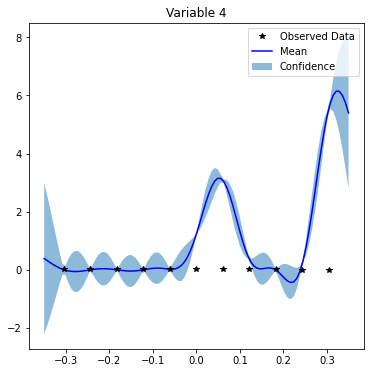

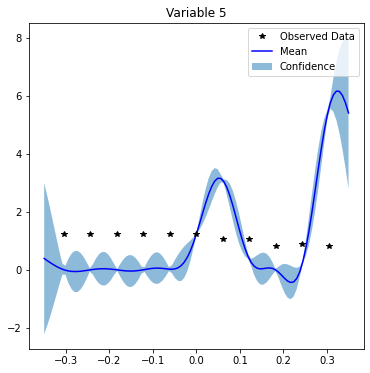

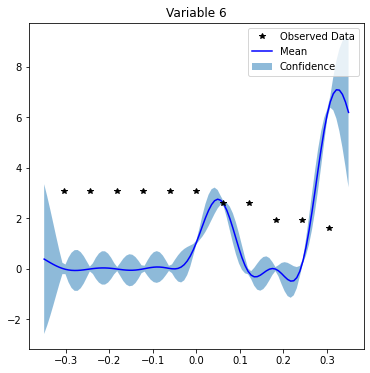

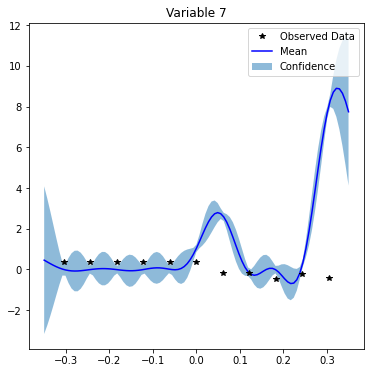

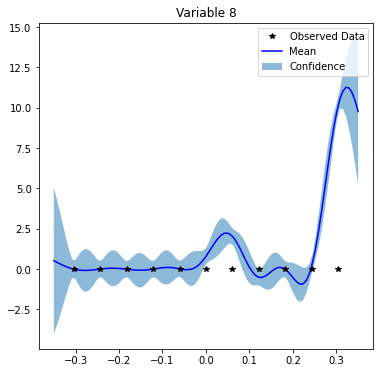

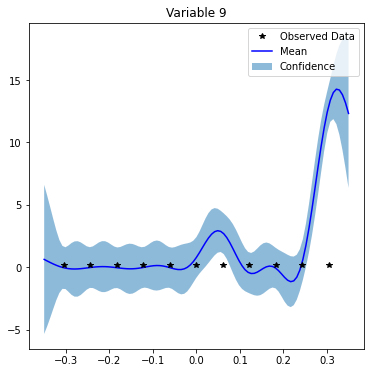

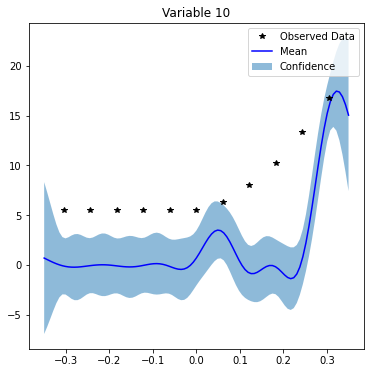

In [13]:
# Initialize plot
data_points_x = train_x.detach().numpy()
data_points_y = train_y.detach().numpy()
x_axis = test_x.detach().numpy()
mean_np = multitask_mean.numpy()
lb_np = multitask_lower.numpy()
ub_np = multitask_upper.numpy()
for i in range(mean_np.shape[-1]):
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    # Plot training data as black stars
    ax.plot(data_points_x, data_points_y[i,:], 'k*',zorder = 10)
    # Predictive mean as blue line
    ax.plot(x_axis, mean_np[:, i], 'b',zorder = 5)
    # Shade in confidence
    ax.fill_between(x_axis, lb_np[:, i], ub_np[:, i], alpha=0.5, zorder = 0)

    #ax.set_ylim([min(lower[:, i-1].numpy())-3, max(upper[:, i-1].numpy())+3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Variable {i}')


## Indipendent
Models follow the trend better

In [14]:
# make predictions

# Set into eval mode
indipendent_models.eval()
indipendent_likelihoods.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-0.35, 0.35, 101)
    predictions = indipendent_likelihoods(*indipendent_models(*[test_x for i in range(train_y.shape[0])]))
    indipendent_mean = [prediction.mean for prediction in predictions]
    bounds = [prediction.confidence_region() for prediction in predictions]

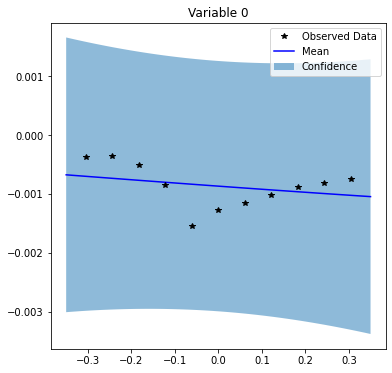

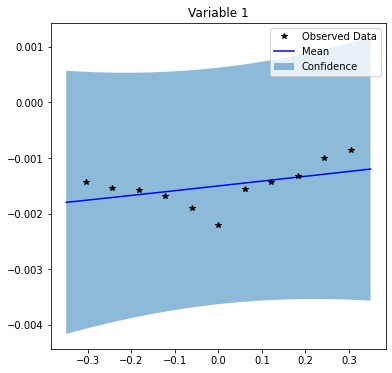

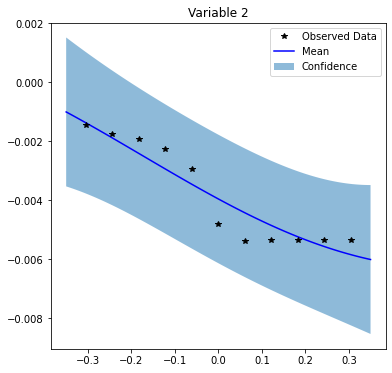

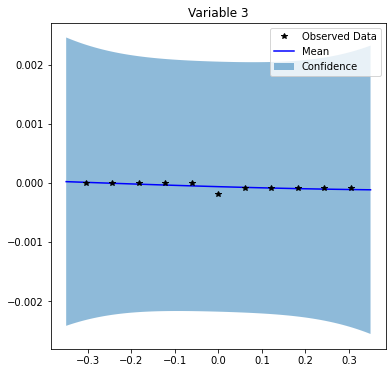

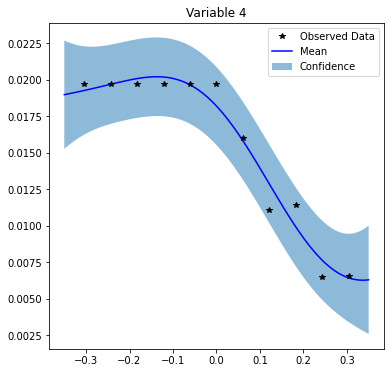

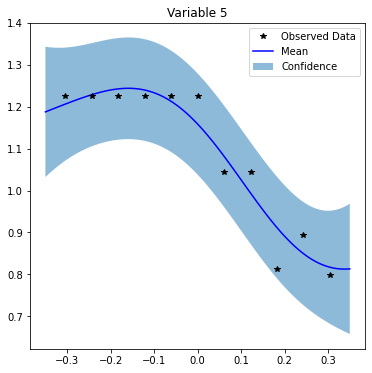

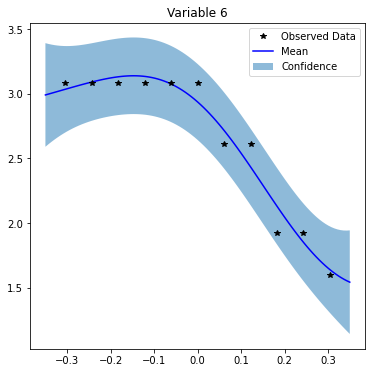

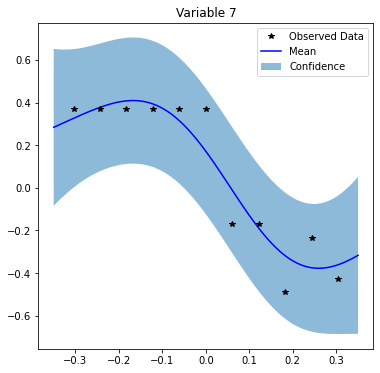

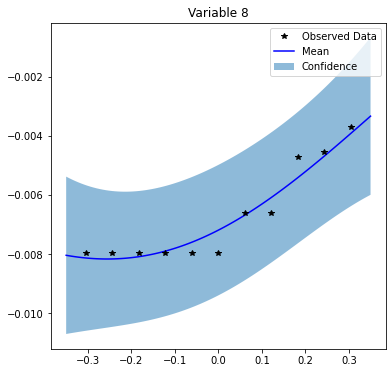

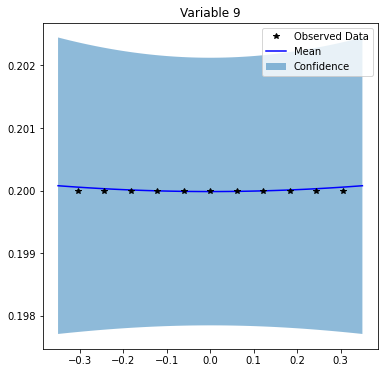

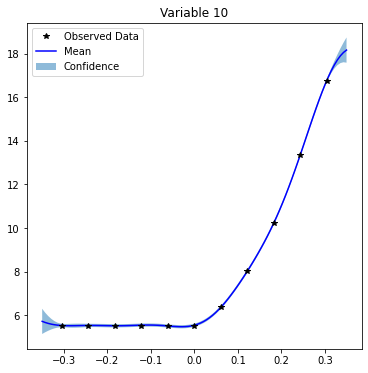

In [15]:
# Initialize plot
mean_np = []
lb_np = []
ub_np = []
for mean_,b_ in zip(indipendent_mean,bounds):
    lb_,ub_ = b_
    mean_np.append(mean_.numpy())
    lb_np.append(lb_.numpy())
    ub_np.append(ub_.numpy())
mean_np = np.asarray(mean_np).T
lb_np = np.asarray(lb_np).T
ub_np = np.asarray(ub_np).T

for i in range(mean_np.shape[-1]):
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    # Plot training data as black stars
    ax.plot(data_points_x, data_points_y[i,:], 'k*',zorder = 10)
    # Predictive mean as blue line
    ax.plot(x_axis, mean_np[:, i], 'b',zorder = 5)
    # Shade in confidence
    ax.fill_between(x_axis, lb_np[:, i], ub_np[:, i], alpha=0.5, zorder = 0)

    #ax.set_ylim([min(lower[:, i-1].numpy())-3, max(upper[:, i-1].numpy())+3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Variable {i}')
